![AES CEE Masthead](https://kyrill.ias.sdsmt.edu/wjc/eduresources/AES_CEE_Masthead.png)
# Backdoor Access of GHCND

In [1]:
################################################################
#
# Loading Version Information
#

import numpy                as np

import xarray               as xr
import cf_xarray.datasets   as cf

import pandas               as pd

import requests             as requests
import os                   as os

import matplotlib.pyplot    as plt
import geopandas            as gpd
import seaborn              as sns

import cartopy.crs          as ccrs  
import cartopy.feature      as cfeature
import cartopy.io.img_tiles as cimgt
import cartopy.mpl          as cmpl

import seaborn as sns

custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False}

sns.set_theme(style="ticks", rc=custom_params)


from   metpy.plots        import USCOUNTIES



from nco import Nco
from nco.custom import Atted



import asyncio
from noaa_cdo_api import NOAAClient, Extent
    
from pyncei  import            NCEIBot, NCEIResponse


# Use your own dang token

apiToken = "xxinINENYhApGNjsGZjRpsNbAtSroeky"

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges
#
################################################################

In [2]:
################################################################
#
# User Mod Area
#

output_directory = "./ghcnd_data/"

fips_code_id     = "FIPS:46" #

country_col      = "USA"
state_col        = "SD"

os.makedirs((output_directory + country_col + "/" + state_col), exist_ok=True)


prefix           = "GHCND__" + country_col + "-" + state_col

ncdc_ghcnd       = "https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/"

# also including our half-day increment to set time-bounds

half_day = np.int64(43200000000000).astype("timedelta64[ns]")

#
################################################################

In [3]:
len(fips_code_id)                  

7

In [4]:
##############################################
#
# NetCDF LUT/Metadata Tables
#

GHCND_to_variable_names = {"TMAX":"maximum_air_temperature",
                           "TMIN":"minimum_air_temperature",
                           "TAVG":"mean_air_temperature",
                           "PRCP":"precipitation_amount",
                           "SNOW":"thickness_of_snowfall_amount",
                           "SNWD":"surface_snow_thickness",
                           "WESD":"liquid_water_content_of_surface_snow",
                           "WESF":"liquid_water_equivalent_snowfall_amount",
                           "AWND":"mean_wind_speed",
                           "AWDR":"mean_wind_from_direction",
                           "WT01":"weather_event_fog",
                           "WT02":"weather_event_heavy_fog",
                           "WT03":"weather_event_thunder",
                           "WT04":"weather_event_ice_pellets",
                           "WT05":"weather_event_hail",
                           "WT06":"weather_event_rime",
                           "WT07":"weather_event_dist",
                           "WT08":"weather_event_smoke",
                           "WT09":"weather_event_blowing_snow",
                           "WT10":"weather_event_tornado",
                           "WT11":"weather_event_high_wind",
                           "WT12":"weather_event_blowing_spray",
                           "WT13":"weather_event_mist",
                           "WT14":"weather_event_drizzle",
                           "WT15":"weather_event_freezing_drizzle",
                           "WT16":"weather_event_rain",
                           "WT17":"weather_event_freezing_rain",
                           "WT18":"weather_event_snow",
                           "WT19":"weather_event_unknown_precip",
                           "WT21":"weather_event_ground_fog",
                           "WT22":"weather_event_ice_fog",
                           "ADPT":"dew_point_temperature",
                           "ASLP":"air_pressure_at_sea_level",
                           "ASTP":"surface_air_pressure",
                           "AWBT":"wet_bulb_temperature",
                           "EVAP":"water_potential_evaporation_amount",
                           "PSUN":"percent_of_possible_sunshine",
                           "RHAV":"mean_relative_humidity",
                           "RHMN":"min_relative_humidity",
                           "RHMX":"max_relative_humidity",
                           "TAXN":"mean_estimated_air_temperature",
                           "TSUN":"duration_of_sunshine",
                           "WSFG":"wind_speed_of_gust",
                           "WSF1":"maximum_1_minute_wind_speed",
                           "WSF2":"maximum_2_minute_wind_speed"}

GHCND_to_scale          = {"TMAX":0.1,
                           "TMIN":0.1,
                           "TAVG":0.1,
                           "PRCP":0.1,
                           "SNOW":0.001,
                           "SNWD":0.001,
                           "WESD":0.1,
                           "WESF":0.1,
                           "AWND":0.1,
                           "AWDR":1.0,
                           "WT01":1.0,
                           "WT02":1.0,
                           "WT03":1.0,
                           "WT04":1.0,
                           "WT05":1.0,
                           "WT06":1.0,
                           "WT07":1.0,
                           "WT08":1.0,
                           "WT09":1.0,
                           "WT10":1.0,
                           "WT11":1.0,
                           "WT12":1.0,
                           "WT13":1.0,
                           "WT14":1.0,
                           "WT15":1.0,
                           "WT16":1.0,
                           "WT17":1.0,
                           "WT18":1.0,
                           "WT19":1.0,
                           "WT21":1.0,
                           "WT22":1.0,
                           "ADPT":0.1,
                           "ASLP":0.1,
                           "ASTP":0.1,
                           "AWBT":0.1,
                           "EVAP":0.1,
                           "PSUN":1.0,
                           "RHAV":1.0,
                           "RHMN":1.0,
                           "RHMX":1.0,
                           "TAXN":0.1,
                           "TSUN":1.0,
                           "WSFG":0.1,
                           "WSF1":0.1,
                           "WSF2":0.1}

GHCND_to_offset         = {"TMAX":0.0,
                           "TMIN":0.0,
                           "TAVG":0.0,
                           "PRCP":0.0,
                           "SNOW":0.0,
                           "SNWD":0.0,
                           "WESD":0.0,
                           "WESF":0.0,
                           "AWND":0.0,
                           "AWDR":0.0,
                           "WT01":0.0,
                           "WT02":0.0,
                           "WT03":0.0,
                           "WT04":0.0,
                           "WT05":0.0,
                           "WT06":0.0,
                           "WT07":0.0,
                           "WT08":0.0,
                           "WT09":0.0,
                           "WT10":0.0,
                           "WT11":0.0,
                           "WT12":0.0,
                           "WT13":0.0,
                           "WT14":0.0,
                           "WT15":0.0,
                           "WT16":0.0,
                           "WT17":0.0,
                           "WT18":0.0,
                           "WT19":0.0,
                           "WT21":0.0,
                           "WT22":0.0,
                           "ADPT":0.0,
                           "ASLP":0.0,
                           "ASTP":0.0,
                           "AWBT":0.0,
                           "EVAP":0.0,
                           "PSUN":0.0,
                           "RHAV":0.0,
                           "RHMN":0.0,
                           "RHMX":0.0,
                           "TAXN":0.0,
                           "TSUN":0.0,
                           "WSFG":0.0,
                           "WSF1":0.0,
                           "WSF2":0.0}


GHCND_to_standard_names = {"TMAX":"air_temperature",
                           "TMIN":"air_temperature",
                           "TAVG":"air_temperature",
                           "PRCP":"precipitation_amount",
                           "SNOW":"thickness_of_snowfall_amount",
                           "SNWD":"surface_snow_thickness",
                           "WESD":"liquid_water_content_of_surface_snow",
                           "WESF":"liquid_water_equivalent_snowfall_amount",
                           "AWND":"mean_wind_speed",
                           "AWDR":"mean_wind_from_direction",
                           "WT01":"",
                           "WT02":"",
                           "WT03":"",
                           "WT04":"",
                           "WT05":"",
                           "WT06":"",
                           "WT07":"",
                           "WT08":"",
                           "WT09":"",
                           "WT10":"",
                           "WT11":"",
                           "WT12":"",
                           "WT13":"",
                           "WT14":"",
                           "WT15":"",
                           "WT16":"",
                           "WT17":"",
                           "WT18":"",
                           "WT19":"",
                           "WT21":"",
                           "WT22":"",
                           "ADPT":"dew_point_temperature",
                           "ASLP":"air_pressure_at_sea_level",
                           "ASTP":"surface_air_pressure",
                           "AWBT":"wet_bulb_temperature",
                           "EVAP":"water_potential_evaporation_amount",
                           "PSUN":"",
                           "RHAV":"relative_humidity",
                           "RHMN":"relative_humidity",
                           "RHMX":"relative_humidity",
                           "TAXN":"air_temperature",
                           "TSUN":"duration_of_sunshine",
                           "WSFG":"wind_speed_of_gust",
                           "WSF1":"wind_speed",
                           "WSF2":"wind_speed"}

GHCND_to_long_names     = {"TMAX":"2-m Maximum Daily Air Temperature",
                           "TMIN":"2-m Minimium Daily Air Temperature",
                           "TAVG":"2-m Mean Daily Air Temperature",
                           "PRCP":"Daily Total Precipitation",
                           "SNOW":"Daily Total Snowfall",
                           "SNWD":"Snow Depth on Surface",
                           "WESD":"Liquid Snow Water Equivalent Depth on Surface",
                           "WESF":"Liquid Snowfall Water Equivalent Depth on Surface",
                           "AWND":"Mean Daily Wind Speed",
                           "AWDR":"Mean Daily Wind Origin Direction",
                           "WT01":"WX: Fog, Ice Fog, or Freezing Fog",
                           "WT02":"WX: Heavy Fog or Heavy Freezing Fog",
                           "WT03":"WX: Thunder",
                           "WT04":"WX: Ice Pellets, Sleet, Snow Pellets, or Small Hail",
                           "WT05":"WX: Hail",
                           "WT06":"WX: Glaze or Rime ",
                           "WT07":"WX: Dust, Volcanic Ash, Blowing Dust, Blowing Sand, or Blowing Obstruction",
                           "WT08":"WX: Smoke or Haze",
                           "WT09":"WX: Blowing or Drifting Snow",
                           "WT10":"WX: Tornado, Waterspout, or Funnel Cloud",
                           "WT11":"WX: High or Damaging winds",
                           "WT12":"WX: Blowing Spray",
                           "WT13":"WX: Mist",
                           "WT14":"WX: Drizzle",
                           "WT15":"WX: Freezing Drizzle",
                           "WT16":"WX: Rain",
                           "WT17":"WX: Freezing Rain",
                           "WT18":"WX: Snow, Snow pellets, Snow grains, or Ice Crystals",
                           "WT19":"WX: Unknown Source of Precipitation",
                           "WT21":"WX: Ground Fog",
                           "WT22":"WX: Ice Fog or Freezing Fog",
                           "ADPT":"2-m Average Daily Dew Point Temperature",
                           "ASLP":"Mean Daily Pressure Reduced to Mean Sea Level",
                           "ASTP":"Mean Daily Surface Pressure",
                           "AWBT":"2-m Average Daily Wet Bulb Temperature",
                           "EVAP":"Total Daily Measured Pan Evaporation",
                           "PSUN":"Percent of Potential Sunshine",
                           "RHAV":"2-m Average Daily Relative Humidity",
                           "RHMN":"2-m Minimum Daily Relative Humidity",
                           "RHMX":"2-m Maximum Daily Relative Humidity",
                           "TAXN":"2-m Mean Calculated Daily Air Temperature",
                           "TSUN":"Duration of Sunshine",
                           "WSFG":"wind_speed_of_gust",
                           "WSF1":"wind_speed",
                           "WSF2":"wind_speed"}

GHCND_to_units          = {"TMAX":"degC",
                           "TMIN":"degC",
                           "TAVG":"degC",
                           "PRCP":"kg m-2",
                           "SNOW":"m",
                           "SNWD":"m",
                           "WESD":"kg m-2",
                           "WESF":"kg m-2",
                           "AWND":"m s-1",
                           "AWDR":"degrees_from",
                           "WT01":"",
                           "WT02":"",
                           "WT03":"",
                           "WT04":"",
                           "WT05":"",
                           "WT06":"",
                           "WT07":"",
                           "WT08":"",
                           "WT09":"",
                           "WT10":"",
                           "WT11":"",
                           "WT12":"",
                           "WT13":"",
                           "WT14":"",
                           "WT15":"",
                           "WT16":"",
                           "WT17":"",
                           "WT18":"",
                           "WT19":"",
                           "WT21":"",
                           "WT22":"",
                           "ADPT":"degC",
                           "ASLP":"hPa",
                           "ASTP":"hPa",
                           "AWBT":"degC",
                           "EVAP":"kg m-2",
                           "PSUN":"percent",
                           "RHAV":"percent",
                           "RHMN":"percent",
                           "RHMX":"percent",
                           "TAXN":"degC",
                           "TSUN":"minutes",
                           "WSFG":"m s-1",
                           "WSF1":"m s-1",
                           "WSF2":"m s-1"}

GHCND_to_cellmethods    = {"TMAX":"time:maximum",
                           "TMIN":"time:minimum",
                           "TAVG":"time:mean",
                           "PRCP":"time:sum",
                           "SNOW":"time:sum",
                           "SNWD":"time:point",
                           "WESD":"time:point",
                           "WESF":"time:sum",
                           "AWND":"time:mean",
                           "AWDR":"time:mean",
                           "WT01":"time:point",
                           "WT02":"time:point",
                           "WT03":"time:point",
                           "WT04":"time:point",
                           "WT05":"time:point",
                           "WT06":"time:point",
                           "WT07":"time:point",
                           "WT08":"time:point",
                           "WT09":"time:point",
                           "WT10":"time:point",
                           "WT11":"time:point",
                           "WT12":"time:point",
                           "WT13":"time:point",
                           "WT14":"time:point",
                           "WT15":"time:point",
                           "WT16":"time:point",
                           "WT17":"time:point",
                           "WT18":"time:point",
                           "WT19":"time:point",
                           "WT21":"time:point",
                           "WT22":"time:point",
                           "ADPT":"time:mean",
                           "ASLP":"time:mean",
                           "ASTP":"time:mean",
                           "AWBT":"time:mean",
                           "EVAP":"time:sum",
                           "PSUN":"time:sum",
                           "RHAV":"time:mean",
                           "RHMN":"time:minimum",
                           "RHMX":"time:maximum",
                           "TAXN":"time:mean",
                           "TSUN":"time:sum",
                           "WSFG":"time:maximum",
                           "WSF1":"time:maximum",
                           "WSF2":"time:maximum"}

retainable_variables = list(GHCND_to_units.keys())

    
#
##############################################

In [5]:
GHCN_metadata_df = pd.read_csv(filepath_or_buffer = "http://kyrill.ias.sdsmt.edu:8080/thredds/fileServer/CLASS_Examples/GHCNd_Metadata.csv",
                               index_col          = "index")


retainable_variables    = GHCN_metadata_df.index.to_list()

GHCND_to_variable_names = GHCN_metadata_df["variable_name"].to_dict()
GHCND_to_long_names     = GHCN_metadata_df["long_name"].to_dict()
GHCND_to_standard_names = GHCN_metadata_df["standard_name"].to_dict()
GHCND_to_units          = GHCN_metadata_df["units"].to_dict()
GHCND_to_scale          = GHCN_metadata_df["scale"].to_dict()
GHCND_to_offset         = GHCN_metadata_df["offset"].to_dict()
GHCND_to_cellmethods    = GHCN_metadata_df["cell_methods"].to_dict()

GHCN_metadata_df

,variable_name,long_name,standard_name,units,scale,offset,cell_methods
index,,,,,,,
ACMC,mean_midnight_to_midnight_mean_cloudiness_auto...,Average cloudiness midnight to midnight from 3...,cloud_area_fraction,percent,1.0,0.0,time:mean
ACMH,mean_midnight_to_midnight_mean_cloudiness_manual,Average cloudiness midnight to midnight from m...,cloud_area_fraction,percent,1.0,0.0,time:mean
ACSC,mean_sunrise_to_sunset_mean_cloudiness_automated,Average cloudiness sunrise to sunset from 30-s...,cloud_area_fraction,percent,1.0,0.0,time:mean
ACSH,mean_sunrise_to_sunset_mean_cloudiness_manual,Average cloudiness sunrise to sunset from manu...,cloud_area_fraction,percent,1.0,0.0,time:mean
ADPT,dew_point_temperature,2-m Average Daily Dew Point Temperature,dew_point_temperature,degC,0.1,0.0,time:mean
...,...,...,...,...,...,...,...
WV01,near_weather_event_fog,"Near WX: Fog, Ice Fog, or Freezing Fog",NaN,NaN,1.0,0.0,time:point
WV03,near_weather_event_thunder,Near WX: Thunder,NaN,NaN,1.0,0.0,time:point
WV07,near_weather_event_dust,"Near WX: Dust, Ash, Blowing Dust, Blowing Sand...",NaN,NaN,1.0,0.0,time:point


In [6]:
################################################################
#
# Access NCEI CDO Web Services.
#

ncei = NCEIBot(token       = apiToken,
               wait        = 10, #,max_retries = 20
               cache_name  = "./") #

#
################################################################

In [7]:
################################################################
#
# Access GHCND Stations based on geographic criteria
#

ncei = NCEIBot(token       = apiToken,
               wait        = 10, #,max_retries = 20
               cache_name  = "./")

stations = ncei.get_stations(datasetid  =      "GHCND",
                             locationid = fips_code_id,
                             limit      =         1000)

n_stations = stations.total()
print("total_stations:", n_stations)



stations_df = stations.to_dataframe()

stations_df["nc_file"] = ""

stations_df.set_index('id', inplace=True)

stations_df = stations_df.reindex(columns    =[*stations_df.columns.tolist(), 
                                               *retainable_variables], 
                                  fill_value = 0.)

stations_df  = stations_df.drop(columns=["url","retrieved"])

data_volume = (((stations_df["maxdate"]-stations_df["mindate"]).values.astype("float") / 86400. / 365.25 / 1e9) * stations_df["datacoverage"].values)
stations_df["data_volume"] = data_volume

#
################################################################

total_stations: 1193


0.19071868583162216 143.90276741957564


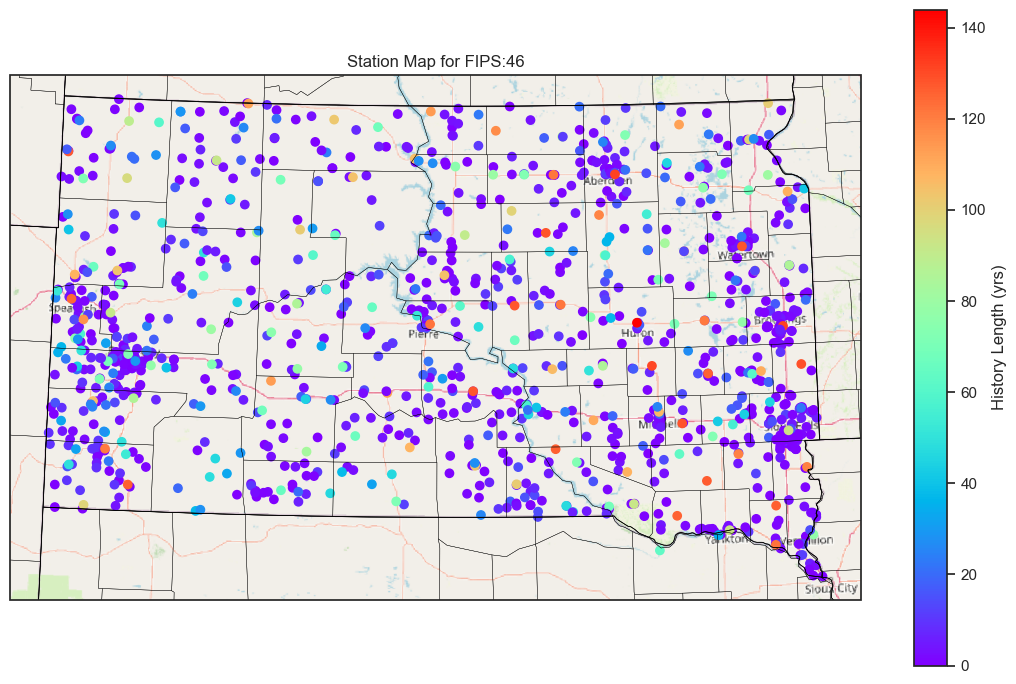

In [8]:
##############################################
#
# Make a map with Google Maps
#


fig = plt.figure(figsize=(11, 7))

# create a simple localized platform (I like Transverse Mercator customized on my location)

myproj = ccrs.TransverseMercator(central_latitude=stations_df["latitude"].mean(),
                                 central_longitude=stations_df["longitude"].mean())

# add a plot element just one field aka the "Axes"

ax = fig.add_subplot(1,  # nrows
                     1,  # ncols 
                     1,  # index of figure you're installing
                     projection = myproj)  # cartopy CRS Projection

# Request Map Tiles

map_tiles = cimgt.OSM(desired_tile_form="RGB")

# Lay down the map tiles 


county_zoom = 12
state_zoom  = 7

if (len(fips_code_id) == 7):
    zoom_level = state_zoom
else:
    zoom_level = county_zoom


ax.add_image(map_tiles, zoom_level)
#
sc = stations_df.plot(ax        =              ax, 
                      column    = stations_df["data_volume"],
                      transform = ccrs.Geodetic(),
                      cmap      = plt.cm.rainbow, 
                      legend    = True,
                      vmin      = 0,
                     legend_kwds={"label": "History Length (yrs)"})

print(min(stations_df["data_volume"]), max(stations_df["data_volume"]))

# Good People Label their Plots

ax.set_title("Station Map for "+fips_code_id)

ax.add_feature(feature    = cfeature.STATES,
               linewidths = 0.5,
               facecolor  = 'none')
ax.add_feature(feature    = cfeature.COASTLINE,
               linewidths = 0.5,
               facecolor  = 'none')
ax.add_feature(feature    = USCOUNTIES, 
               linewidths = 0.25,
               facecolor  = 'none')

# Display and Close Graph

plt.tight_layout()
png_inventory = output_directory + prefix + "__Inventory_"+fips_code_id.replace(":", "-")+".png"
plt.savefig(png_inventory)

#
##############################################

In [9]:
##############################################
#
# Loop Stations
#

n = np.int32(0)

for stationid, station_row in stations_df.iterrows():

    n = n + np.int32(1)

    ##############################################
    #
    # Pull Station Data
    #

    mystation = station_row.to_dict()
        
    #
    ##############################################
    
    ##############################################
    #
    # Download Station Data
    #
    
    # Remote CSV File
    
    ncdc_csv_file = ncdc_ghcnd + stationid.replace("GHCND:","") +".csv"
    r             = requests.head(ncdc_csv_file)
    print(str(n).zfill(5)+":"+str(n_stations).zfill(5)+"; "+stationid + "; " + mystation["name"])

    if (r.status_code == 200):

        ##############################################
        #
        # Pull CSV File
        #
            
        df_in = pd.read_csv(filepath_or_buffer = ncdc_csv_file,
                            low_memory         =         False)
        
        # Clean DataFrame
        
        df_in = df_in.filter(regex   = '^(?!.*ATTRIBUTES)')
        
        df_in.drop(labels  = ["NAME",
                              "ELEVATION",
                              "LONGITUDE",
                              "LATITUDE",
                              "STATION"],
                   axis    = "columns",
                   inplace = True)
        
        df_in.rename(columns = {"DATE":"time"},
                     inplace =            True)
        
        df_in["time"] = pd.to_datetime(df_in["time"]) #+ half_day
        
        df_in.set_index(keys    = "time",
                        inplace =   True)
        
        df_in.sort_index(inplace=True)
        
        # Create Full Time Range
        
        full_time_range = np.arange(start = df_in.index.min(), 
                                    stop  = df_in.index.max()+np.timedelta64(1, 'D'),
                                    dtype =      'datetime64[D]').astype("datetime64[ns]")

        n_records = full_time_range.size
        # Fill in Times 
        
        df_in = df_in.reindex(labels = full_time_range,
                              axis   = "rows",
                              method = None)
        
        # Drop Unused Variables 
        
        variables_in_ds     = list(df_in.keys())
        
        dropped_variables   = list(set(variables_in_ds).difference(retainable_variables))
        available_variables = list(set(variables_in_ds).intersection(retainable_variables))

        
        df_in.drop(labels  = dropped_variables,
                   axis    = "columns",
                   inplace = True)
        
        #
        ##############################################
        
        ##############################################
        #
        # Create Xarray DataSet
        #
        # 
        
        ds = df_in.to_xarray()
        
        #
        ##############################################
        
        ##############################################
        #
        # Load Attributes into Variables
        #
        encoding = {"time"       :{"units":"seconds since 1970-01-01 00:00:00",
                                   "dtype":np.float64},
                    "time_bounds":{"units":"seconds since 1970-01-01 00:00:00",
                                   "dtype":np.float64}}

        any_weather = np.zeros(ds.sizes["time"])

        
        for variable in available_variables:
            ds[variable].values = ds[variable].values *  GHCND_to_scale[variable] + GHCND_to_offset[variable]
            #print("   "+variable, 
            #      np.nanmin(ds[variable].values), 
            #      np.nanmax(ds[variable].values))
            ds[variable].attrs["long_name"]     = GHCND_to_long_names[variable]
            ds[variable].attrs["description"]   = GHCND_to_long_names[variable]
            ds[variable].attrs["cell_methods"]  = GHCND_to_cellmethods[variable]
            ds[variable].attrs["coordinates"]   = "time lat lon alt station_id"
            if (GHCND_to_standard_names[variable] != ""):
                ds[variable].attrs["standard_name"] = GHCND_to_standard_names[variable]
            if (GHCND_to_units[variable]          != ""):
                ds[variable].attrs["units"]         = GHCND_to_units[variable]
            
                
            if variable.startswith("WT"):
                ds[variable].values = np.nan_to_num(x    = ds[variable].values,
                                                    copy =              True, 
                                                    nan  =                 0)
                encoding[GHCND_to_variable_names[variable]] = dict(zlib         =             True, 
                                                                   complevel    =                5, 
                                                                   dtype        =         np.int16,
                                                                   _FillValue   = np.int16(-32767))
                any_weather = any_weather + ds[variable].values
                
            else:
                encoding[GHCND_to_variable_names[variable]] = dict(zlib         =                      True, 
                                                                   complevel    =                         5, 
                                                                   dtype        =                  np.int16,
                                                                   _FillValue   =          np.int16(-32767),
                                                                   scale_factor =  GHCND_to_scale[variable],
                                                                   add_offset   = GHCND_to_offset[variable])
                
            number_complete_records = n_records - np.isnan(ds[variable].values).sum()

            stations_df.loc[stationid, variable]  = 1.0*number_complete_records/n_records
            stations_df.loc[stationid, "mindate"] = df_in.index.min().strftime("%Y-%m-%d")
            stations_df.loc[stationid, "maxdate"] = df_in.index.max().strftime("%Y-%m-%d")
        stations_df.loc[stationid,"nRecords" ]    = np.int32(n_records)

        #
        # Clean Weather Records
        #

        wx_vars = [item for item in available_variables if item.startswith("WT")]
        #print("   Number of Wx Variables:",len(wx_vars))
        if (len(wx_vars) > 0):
            empty_locations = zero_runs(a = any_weather)
            empty_size      = empty_locations[:,1] - empty_locations[:,0]
            
            weather_mask = np.zeros(n_records) + 1
            #print("     :",empty_size.size, empty_locations)

            for i in range(empty_size.size):
                if empty_size[i] > 365:
                    #print("      --",empty_locations[i,0],empty_locations[i,1]-1,n_records)
                    weather_mask[empty_locations[i,0]:empty_locations[i,1]-1] = np.nan
        
            for wx_var in wx_vars:
                ds[wx_var].values       = ds[wx_var].values * weather_mask   
                number_complete_records = n_records - np.isnan(ds[wx_var].values).sum()

            stations_df.loc[stationid, variable]  = 1.0*number_complete_records/n_records
           
        # Time attributes (also moving the time to the center of the day)
        
        ds["time"].attrs["long_name"]          = "time"
        ds["time"].attrs["description"]        = "time"
        ds["time"].attrs["standard_name"]      = "time"
        ds["time"].attrs["bounds"]             = "time_bounds"
        ds["time"]                             = ds["time"] + half_day

        # adding time bounds

        ds = ds.cf.add_bounds(keys = "time",
                              dim  = "time")
        ds["time_bounds"].attrs["long_name"]   = "time bounds"
        ds["time_bounds"].attrs["description"] = "time bounds"

        
        # swap CDO variable names for more formal names
        
        filtered_dict = dict((k, GHCND_to_variable_names[k]) for k in available_variables if k in GHCND_to_variable_names)
        
        ds = ds.rename_vars(filtered_dict)
        
        #
        ##############################################
        
        ##############################################
        #
        # Creating the remaining variables and attributes needed
        #   for a CF-Metadata Time Series.
        #
        
        # Pull our metadata for our requested station
        
        mystation = stations_df.loc[stationid].to_dict()
        
        # Get our location data loaded
        
        ds["lat"]          = xr.DataArray(data  = mystation["latitude"],
                                          attrs = {"long_name"    :"latitude",
                                                   "description"  :"latitude",
                                                   "standard_name":"latitude",
                                                   "units"        :"degrees_north"})
        
        ds["lon"]          = xr.DataArray(data  = mystation["longitude"],
                                          attrs = {"long_name"    :"longitude",
                                                   "description"  :"longitude",
                                                   "standard_name":"longitude",
                                                   "units"         :"degrees_east"})
        
        ds["alt"]          = xr.DataArray(data  = mystation["elevation"],
                                          attrs = {"long_name"    :"station elevation",
                                                   "description"  :"station elevation",
                                                   "standard_name":"height",
                                                   "positive"     :"up",
                                                   "axis"         :"Z",
                                                   "units"        :"m"})
        
        ds["station_name"] = xr.DataArray(data  = mystation["name"],
                                          attrs = {"long_name"    :"station name",
                                                   "description"  :"station name"})
        
        ds["station_id"]   = xr.DataArray(data  = stationid,
                                          attrs = {"long_name"    :"station id",
                                                   "description"  :"station id",
                                                   "cf_role"      :"timeseries_id"})
        
        
        ds.attrs["title"]                       = "Global Historical Climatology Network daily (GHCNd)" 
        ds.attrs["institution"]                 = "NOAA Center for Environmental Prediction (NCEI)" 
        ds.attrs["title"]                       = "Global Historical Climatology Network daily (GHCNd)" 
        ds.attrs["references"]                  = "https://doi.org/10.1175/JTECH-D-11-00103.1" 
        ds.attrs["url"]                         = "https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily"
        ds.attrs["GHCN_Station_Code"]           = stationid
        ds.attrs["Station_Name"]                = mystation["name"]
        ds.attrs["Station_Latitude"]            = mystation["latitude"]
        ds.attrs["Station_Longitude"]           = mystation["longitude"]
        ds.attrs["Station_Elevation_in_Meters"] = mystation["elevation"]
        ds.attrs["Conventions"]                 = "CF-1.8"
        ds.attrs["featureType"]                 = "timeSeries"
        
        #
        ##############################################
        
        ##############################################
        #
        # Bag it!
        #

        output_namestring = (stationid+"__"+mystation["name"]).replace(":", "-").replace(", ", "_").replace(" ", "_") + ".nc"

        stations_df.loc[stationid, "nc_file"] = output_namestring


        filename = output_directory + country_col + "/" + state_col + "/" + output_namestring
        
        ds.close()
        
        ds.to_netcdf(path           = filename,
                     unlimited_dims = "time",
                     engine         = "h5netcdf",
                     encoding       = encoding)
        ds.close()

        nco = Nco()
        opt = [
            Atted("d", "_FillValue", "time", ""),
            Atted("d", "_FillValue", "time_bounds", ""),
            Atted("d", "coordinates", "global", ""),

            Atted("d", "_FillValue", "lat", ""),
            Atted("d", "_FillValue", "lon", ""),
            Atted("d", "_FillValue", "alt", ""),
            Atted("d", "_FillValue", "station_id", ""),
            Atted("d", "_FillValue", "station_name", "")
      ]
        nco.ncatted(input=filename, options=opt)
        
        #
        ##############################################
        
    else:
        print("  -- 404 Error for " + stationid)
        stations_df.loc[stationid,"name"] = "404_Error"
    
    
#
################################################################

00001:01193; GHCND:US009052008; SIOUX FALLS ENVIRON. CANADA, SD US
00002:01193; GHCND:US1SDAR0001; PLANKINTON 5.8 S, SD US
00003:01193; GHCND:US1SDAR0002; STICKNEY 0.2 SSE, SD US
00004:01193; GHCND:US1SDAR0003; WHITE LAKE 10.9 S, SD US
00005:01193; GHCND:US1SDAR0004; STICKNEY 5.4 SSW, SD US
00006:01193; GHCND:US1SDAR0007; PLANKINTON 3.8 W, SD US
00007:01193; GHCND:US1SDAR0008; STICKNEY 3.8 SW, SD US
00008:01193; GHCND:US1SDBD0003; IROQUOIS 10.4 SSW, SD US
00009:01193; GHCND:US1SDBD0007; HURON 6.8 NNE, SD US
00010:01193; GHCND:US1SDBD0008; WOLSEY 4.3 WSW, SD US
00011:01193; GHCND:US1SDBD0009; HITCHCOCK 7.5 WSW, SD US
00012:01193; GHCND:US1SDBD0010; IROQUOIS 5.2 SSW, SD US
00013:01193; GHCND:US1SDBD0016; HURON 1.8 S, SD US
00014:01193; GHCND:US1SDBD0020; HURON 1.3 S, SD US
00015:01193; GHCND:US1SDBD0021; WOLSEY 4.0 ENE, SD US
00016:01193; GHCND:US1SDBD0024; HURON 1.1 NNE, SD US
00017:01193; GHCND:US1SDBD0025; ALPENA 3.3 N, SD US
00018:01193; GHCND:US1SDBF0001; GANN VALLEY 7.8 WNW, SD US


## Saving Metadata to a File

In [10]:
##############################################
#
# Save Metadata File
#

stations_df = stations_df.rename(columns = {"maxdate":"end_date",
                                            "mindate":"start_date"})
stations_df = stations_df[stations_df['name'] != "404_Error"]

csv_inventory = output_directory + prefix + "__Inventory_"+fips_code_id.replace(":", "-")+".csv"

stations_df.to_csv(path_or_buf = csv_inventory,
                   index       =         False)



#
##############################################


## Version Information

In [11]:
fips_code_id.replace(":", "-")

'FIPS-46'

In [13]:
################################################################
#
# Loading Version Information
#

%load_ext version_information
%version_information numpy, xarray, cf_xarray, pandas, pyncei, version_information

#
################################################################

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.12.9 64bit [Clang 18.1.8 ]
IPython 9.3.0
OS macOS 15.5 arm64 arm 64bit
numpy 2.2.6
xarray 2025.4.0
cf_xarray 0.10.5
pandas 2.3.0
pyncei 1.0
version_information 1.0.4
Mon Jun 09 12:20:29 2025 MDT